In [1]:
#импортируем библиотеки

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
import warnings


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score


In [32]:
def replace_outliers(val, low, high):
    """ функция для обработки выбрасов
    val = значение
    low = q_1 - IQR * 1.5
    high = q_3 + IQR * 1.5 """
    
    if val < low:
        return low
    
    elif val > high:
        return high
    
    else:
        return val

In [2]:
train1 = pd.read_csv('train.csv')
test1= pd.read_csv('test.csv')

Описания признаков

1. client_id - идентификатор клиента
2. education - уровень образования
3. sex - пол заемщика
4. age - возраст заемщика
5. car - флаг наличия автомобиля
6. car_type - флаг автомобиля иномарки
7. decline_app_cnt - количество отказанных прошлых заявок
8. good_work - флаг наличия “хорошей” работы
9. bki_request_cnt - количество запросов в БКИ
10. home_address - категоризатор домашнего адреса
11. work_address - категоризатор рабочего адреса
12. income - доход заемщика
13. foreign_passport - наличие загранпаспорта
14. sna - связь заемщика с клиентами банка
15. first_time - давность наличия информации о заемщике
16. score_bki - скоринговый балл по данным из БКИ
17. region_rating - рейтинг региона
18. app_date - дата подачи заявки
19. default - флаг дефолта по кредиту

In [3]:
#  для корректной обработки признаков объединяем трейн и тест в один датасет
train1['sample'] = 1 # помечаем где у нас трейн
test1['sample'] = 0 # помечаем где у нас тест
test1['default'] = 0 # в тесте у нас нет значения

data = test1.append(train1, sort=False).reset_index(drop=True) # объединяем

In [4]:
# осматриваем данные
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [5]:
# проверим датасет на наличие пропусков
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

<AxesSubplot:>

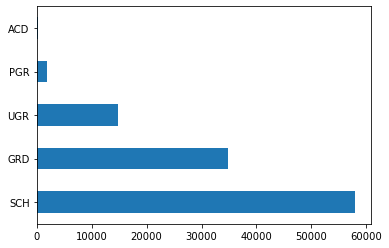

In [6]:
# осмотрим признак
data['education'].value_counts().plot.barh()

In [7]:
# заменяем пропуски с помощью вероятностного присвоения
mask = data["education"].isna()
# считаем статистику распределения значений
p = data["education"].value_counts() / len(data["education"].dropna())
# заполняем пропуски с вероятностью `p`
data.loc[mask, "education"] = \
    np.random.choice(p.index.to_list(), 
                     size=mask.sum(), 
                     p=p.to_list())

In [8]:
# проверим результат 
data.isnull().sum().sum()

0

In [9]:
# преобразуем признак 'app_date' в приемлимый формат и извлечём данные, с которыми можно работать:
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_day'] = data.app_date.dt.day     # извлекли в 
data['app_month'] = data.app_date.dt.month
data["app_weekday"] = data["app_date"].dt.weekday
# удалим теперь уже ненужный столбец
data.drop(["app_date"], axis=1, inplace=True)

In [10]:
## разделим признаки по категориям:

## числовые признаки
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income"]

# бинарные признаки
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные признаки
cat_cols = ["education", "region_rating", "home_address", "work_address", "sna"
                 ,"app_day", "app_month", "app_weekday", "first_time"]

C:\Users\Tanya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


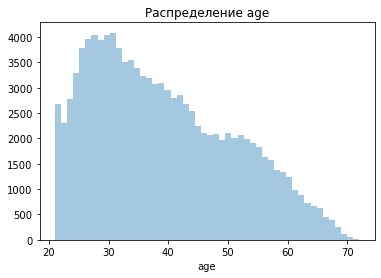

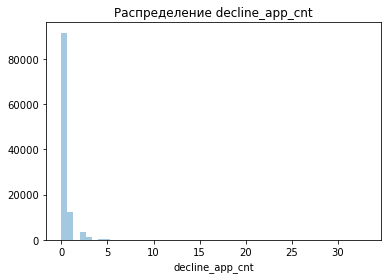

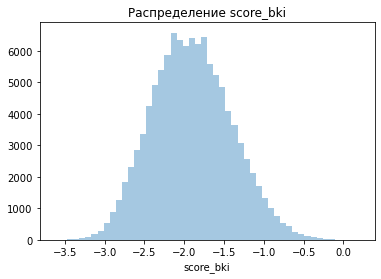

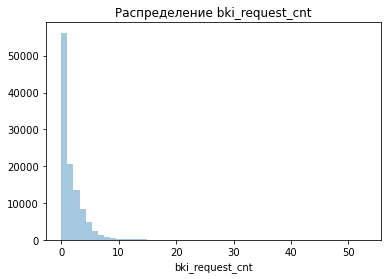

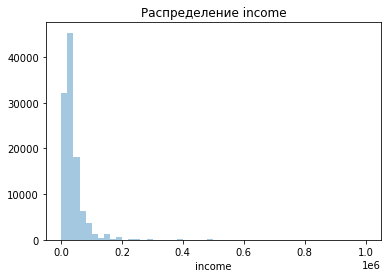

In [11]:
# осмотрим числовые признаки
for col in data[num_cols]:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

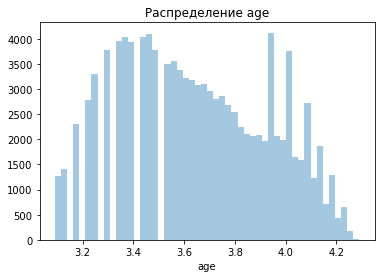

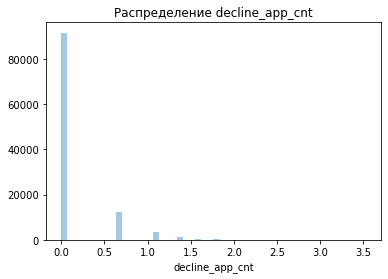

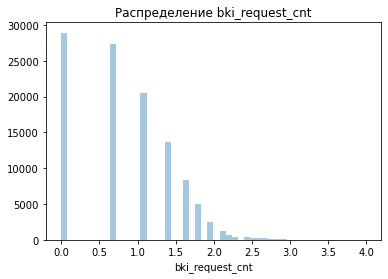

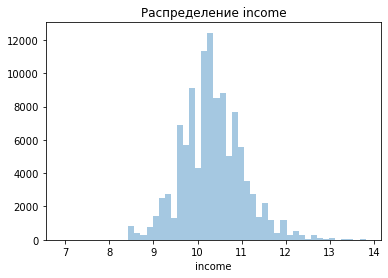

In [12]:
# для более нормального распределения, логарифмируем некоторые признаки
data[["age", "decline_app_cnt", "bki_request_cnt", "income"]] = np.log(data[["age",
                            "decline_app_cnt", "bki_request_cnt", "income"]] + 1)
# и сразу их осмотрим
for col in ("age", "decline_app_cnt", "bki_request_cnt", "income"):
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

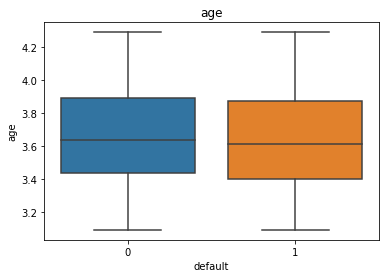

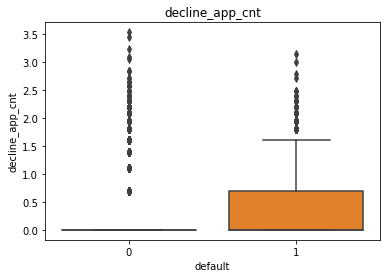

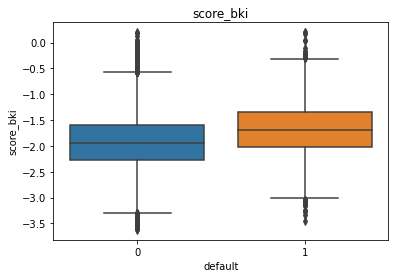

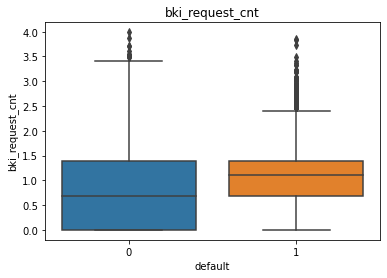

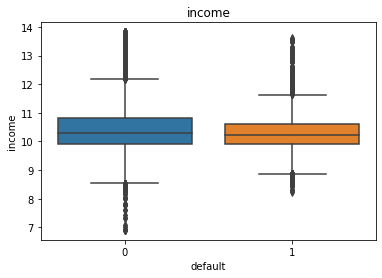

In [13]:
# взглянем на боксплоты числовых переменных, относительно целевой
for i in data[num_cols]:
    plt.figure()
    sns.boxplot(x=data['default'], y = data[i])
    plt.title(i)
    plt.show()

1. возраст дефолтных клиентов меньше
2. дефолтные клиенты часто уже имели отказные заявки 
3. скоринговый балл у дефолтных выше
4. у дефолтных клиентов больше запросов на кредит
5. доход у дефолтных, в среднем, ниже


In [15]:
for col in ('income', 'score_bki'):
    q_1 = np.quantile(data[col], 0.25) 
    q_3 = np.quantile(data[col], 0.75) 
    IQR = q_3 - q_1
    low = q_1 - IQR * 1.5 
    high = q_3 + IQR * 1.5
    data[col] = data[col].map(lambda x: replace_outliers(x, low, high))

<AxesSubplot:>

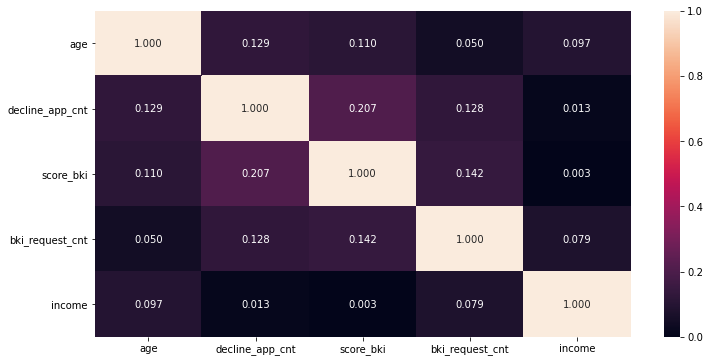

In [16]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(12, 6))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".3f")

На графике можно увидеть небольшую корреляцию между app_month и app_day, decline_app_cnt и score_bki


<AxesSubplot:>

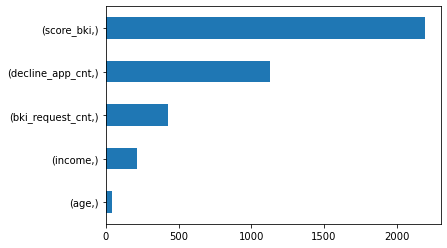

In [17]:
#определяем значимость наших переменных
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index=[data[num_cols].columns])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [18]:
# заменяем бинарные категориальные признаки

label_encoder = LabelEncoder()
for column in data[bin_cols]:
    data[column] = label_encoder.fit_transform(data[column])

<AxesSubplot:>

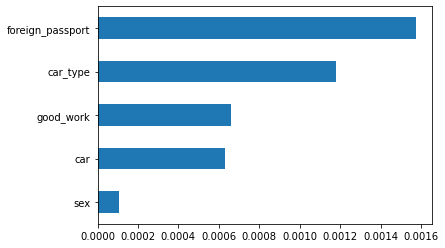

In [19]:
# произведём оценку значимости категориальных бинарных переменных
imp_cat = pd.Series(mutual_info_classif(data[bin_cols], data['default'],
                                     discrete_features =True), index = data[bin_cols].columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

После удаления признаков с низкой значимостью, конечный скор стал ниже, чем без них


In [20]:
#преобразуем education
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['education']))
print(dict(enumerate(label_encoder.classes_))) # чтобы не забыть что куда преобразилось
data['education'] = mapped_education

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [21]:
# воспользуемся dummy-кодированием для категориальных переменных
X_cat = OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)

X_cat = pd.DataFrame(X_cat)

In [22]:
# добавим новые признаки, через комбинацию чиловых признаков
poly = PolynomialFeatures(2, include_bias=False)
poly_data = poly.fit_transform(data[num_cols]) 
poly_cols = poly.get_feature_names(input_features=None)

# создадим из них новый df
poly_df = pd.DataFrame(poly_data, columns=poly_cols)

# сделаем итоговый df для числовых
total_num = data[num_cols].join(poly_df,  how='left')

In [23]:
#стандартизация числовых признаков
total_num = pd.DataFrame(StandardScaler().fit_transform(total_num), columns = total_num.columns)

total_num.head()

,age,decline_app_cnt,score_bki,bki_request_cnt,income,x0,x1,x2,x3,x4,...,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,-0.888776,-0.418815,-0.737663,0.770563,0.711772,-0.888776,-0.418815,-0.737663,0.770563,0.711772,...,-0.323464,0.408619,-0.325013,-0.417889,0.683034,-1.185601,-0.916723,0.536491,0.846954,0.691354
1,0.120447,4.539989,0.804672,0.333797,-2.596453,0.120447,4.539989,0.804672,0.333797,-2.596453,...,6.443462,-3.980130,3.591954,3.700979,-0.856767,-0.020031,1.270745,0.000679,0.045563,-2.394324
2,0.972731,-0.418815,0.429911,-0.281790,-0.046220,0.972731,-0.418815,0.429911,-0.281790,-0.046220,...,-0.323464,0.408619,-0.325013,-0.417889,-0.540132,0.354755,0.424600,-0.543853,-0.284659,-0.078246
3,1.362924,-0.418815,-0.943404,-0.281790,-0.889011,1.362924,-0.418815,-0.943404,-0.281790,-0.889011,...,-0.323464,0.408619,-0.325013,-0.417889,0.935706,-0.013991,-0.643713,-0.543853,-0.341382,-0.890254
4,0.031629,-0.418815,-1.171309,-1.334144,2.010858,0.031629,-0.418815,-1.171309,-1.334144,2.010858,...,-0.323464,0.408619,-0.325013,-0.417889,1.228589,1.268104,-1.763464,-0.903968,-1.314239,2.096875


In [24]:
# объединим обработку в один датасет
data_for_fit = total_num.join(X_cat)
data_for_fit = data_for_fit.join(data[bin_cols])
data_for_fit = data_for_fit.join(data[['sample', 'default']])

In [25]:
# вновь разделимь на тренеровочный и тестовый
train = data_for_fit.query('sample == 1').drop(['sample'], axis=1)
test = data_for_fit.query('sample == 0').drop(['sample'], axis=1)

In [26]:
# подготовим данные к сплину
Y = train['default'].values
train.drop(["default"], axis=1, inplace=True)
test.drop(["default"], axis=1, inplace=True)
X = train.values
test = test.values

In [27]:
# сплитим данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1, shuffle=True)

In [28]:
"""# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = (0.001, 0.1, 1, 10, 100, 1000, 10000)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# Отобразим лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])"""

"# Добавим типы регуляризации\npenalty = ['l1', 'l2']\n\n# Зададим ограничения для параметра регуляризации\nC = (0.001, 0.1, 1, 10, 100, 1000, 10000)\n\n# Создадим гиперпараметры\nhyperparameters = dict(C=C, penalty=penalty)\n\nmodel = LogisticRegression(solver='lbfgs', max_iter=1000)\nmodel.fit(X_train, y_train)\n\n# Создаем сетку поиска с использованием 5-кратной перекрестной проверки\nclf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)\n\nbest_model = clf.fit(X_train, y_train)\n\n# Отобразим лучшие гиперпараметры\nprint('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])\nprint('Лучшее C:', best_model.best_estimator_.get_params()['C'])"

Лучшая регуляризация - l2, с силой регуляризации C = 0.1
станартные параметны логистической регрессии останутся без изменений

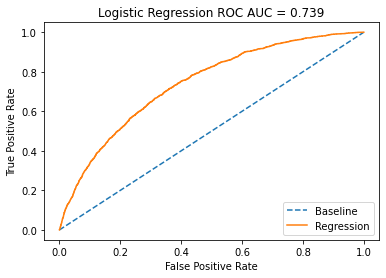

In [29]:
# обозначаем модель
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000)

# обучаем модель
model.fit(X_train, y_train)

# делаем предсказание
probs = model.predict_proba(X_test)
probs = probs[:,1]

#рисуем ROC кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

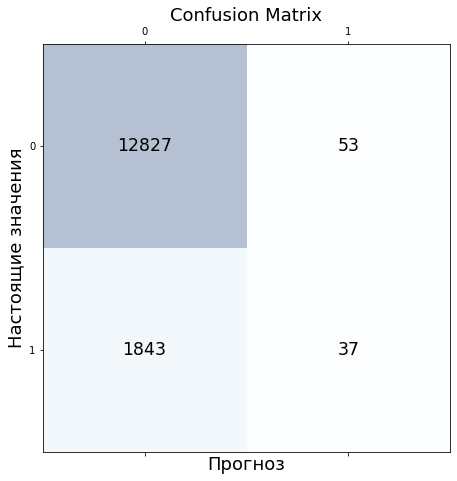

In [30]:
# просмотрим качество присвоения к нужному классу
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Прогноз', fontsize=18)
plt.ylabel('Настоящие значения', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

При визуальном осмотре видно, что наша модель работает недостаточно качественно.
При слабой ошибке второго рода, сильная ошибка первого рода.
В данном случае, это будет значить, что мы не выдадим большое число кредитов клиентам, которые будут в состоянии его вернуть

In [31]:
# коэффициенты нашей модели
coef = np.exp(model.coef_[0]) 

# представим их в виде датафрейма
pd.DataFrame(coef, train.columns)

,0
age,1.224875
decline_app_cnt,1.224996
score_bki,1.245134
bki_request_cnt,0.934140
income,0.983196
...,...
sex,1.284734
car,0.985007
car_type,0.794635
good_work,0.804976
